Remember to:

    (1) Change back to DH parameters instead of IDL parameters (H0, etc.)
    (2) sum over partial bins (in the low energy electron methods)
    (3) off-by-one in the CMB subtraction

# Introduction

In this example, we compare $f_c(z)$ as calculated by DarkHistory against that used in 1604.xxxx.  We are only able to do so if we change the parameters 

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

#Current Working Directory
import os
cwd = os.getcwd()

from pathlib import Path

def tabulate(x, y, f):
    """Return a table of f(x, y)."""
    return np.vectorize(f)(*np.meshgrid(x, y, sparse=True))

In [62]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]

# SET THIS TO TRUE TO USE LATEX
matplotlib.rcParams['text.usetex'] = False

from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

np.set_printoptions(threshold=np.nan)

Now load the transfer functions.  

If we set standard_tfs to True, we use transfer functions that follow the standard H and He ionization histories and only interpolate over rs (to generate these, download from erebus `/zfs/gridgway/transferfuncs/tf_pickled_standard_xe_and_xHe/*full_rs_no_interp.p`, and process it through Example9_TESTS.ipynb with standard_tfs set to True).  

If False, we upload another set of transfer functions in addition to the one above and combine the two sets of transfer functions into one TransferFuncInterps object. The second set of tfs sets xHe=0 and xe (should be translated into xH) to 19 specified values that are interpolated over (to generate these, download `/zfs/gridgway/transferfuncs/tf_pickled_xHe0/*.p` [or is it ../tf_pickled_fine_xe_xHe0/*.p] and process it through Example9_TESTS.ipynb with standard_tfs set to False).

(Interpolation over xHe soon to come)

In [105]:
%autoreload
standard_tfs = False
direc = '/Users/gregoryridgway/Desktop/DM/'

# True if you would like to subtract the CMB off of the transfer functions?
CMB_subtracted=False

if not standard_tfs:
    direc_arr = [direc+'tfs_xHe0/', direc+'tfs_standard_xe_xHe_full_rs/']
    xes = np.array([
        0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.8, -1.4, -1, -.8, -0.65, -0.5, -.24, 0, .2, 0.4, .7, 1.3, 2.2, 3.1, 4]),
        None]
    )
    string_arr = ["_xHe0", "_standard_xe_xHe_full_rs"]
    switching_rs = 1600
else:
    direc_arr = direc+'tfs_standard_xe_xHe_full_rs/'
    xes = None
    string_arr = ["_standard_xe_xHe_full_rs"]

(highengphot_tf_interp,
     lowengphot_tf_interp,
     lowengelec_tf_interp,
     highengdep_interp,
     CMB_engloss_interp
    ) = main.load_trans_funcs(direc_arr, xes, string_arr=string_arr, inverted=False, CMB_subtracted=CMB_subtracted)

if not standard_tfs:
    highengphot_tf_interp.rs_nodes[0] = switching_rs
    lowengphot_tf_interp.rs_nodes[0]  = switching_rs
    lowengelec_tf_interp.rs_nodes[0]  = switching_rs
    highengdep_interp.rs_nodes[0]     = switching_rs
    CMB_engloss_interp.rs_nodes[0]    = switching_rs
    
#     pickle.dump(highengphot_tf_interp, open("/home/gridgway/Desktop/DH_Data/highengphot_tf_interp.p", "wb"))
#     pickle.dump(lowengphot_tf_interp, open("/home/gridgway/Desktop/DH_Data/lowengphot_tf_interp.p", "wb"))
#     pickle.dump(lowengelec_tf_interp, open("/home/gridgway/Desktop/DH_Data/lowengelec_tf_interp.p", "wb"))
#     pickle.dump(highengdep_interp, open("/home/gridgway/Desktop/DH_Data/highengdep_interp.p", "wb"))
#     pickle.dump(CMB_engloss_interp, open("/home/gridgway/Desktop/DH_Data/CMB_engloss_interp.p", "wb"))

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
noninterp
noninterp
noninterp
noninterp
noninterp
Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
noninterp
noninterp
noninterp
noninterp
noninterp
Done.



Downloading ICS transfer functions.  If they haven't been made and pickled already, make them.

In [4]:
direc = "/Users/gregoryridgway/Desktop/DM/tfs_ics/"
ics_file = Path(direc+"ics_thomson_ref_tf.p")

if ics_file.is_file():
    ics_thomson_ref_tf = pickle.load(open(direc+"ics_thomson_ref_tf.p", "rb"))
    ics_rel_ref_tf = pickle.load(open(direc+"ics_rel_ref_tf.p", "rb"))
    engloss_ref_tf = pickle.load(open(direc+"engloss_ref_tf.p", "rb"))
else:
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()
    pickle.dump(ics_thomson_ref_tf, open(direc+"ics_thomson_ref_tf.p", "wb"))
    pickle.dump(ics_rel_ref_tf, open(direc+"ics_rel_ref_tf.p", "wb"))
    pickle.dump(engloss_ref_tf, open(direc+"engloss_ref_tf.p", "wb"))

# Specify Model

In [73]:
#Annihilation or decay?
inj_type = 'decay'

#Annihilate/Decay into
inj_particle = 'photon'

#Useful definitions
if inj_particle == 'electron':
    inj_str = 'elec'
    mass = phys.me
else:
    inj_str = 'phot'
    mass = 0

# Load IDL Files

Download the parameters used in the IDL files (file can be found at `erebus:/zfs/gridgway/transferfuncs/ih_continuous_phot/tf_z_3.000E+03_nstep_6398_logE_1.021E+01_xe_0.000E+00.fits`)

In [74]:
direc = '/Users/gregoryridgway/Desktop/DM/ih_continuous_'+inj_str+'/IDL_runs/'

hdul = fits.open(
    direc
    +'tf_z_3.000E+03_nstep_6398_logE_1.021E+01_xe_0.000E+00.fits'
)
    
data = hdul[1].data

idl_photonspectrum = data.field('photonspectrum')[0]
idl_lowengphot = data.field('lowengphot')[0]
idl_lowengelec = data.field('lowengelec')[0]
idl_energy = data.field('energy')[0]
idl_eleceng = data.field('eleceng')[0]
idl_redshift = data.field('redshift')[0]
idl_cmblosstable = data.field('cmblosstable')[0]
idl_highengdep = data.field('highdeposited_grid')[0]

idl_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('energy')[0]))) * idl_energy
idl_elec_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('eleceng')[0]))) * idl_eleceng

xe_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

The input energies used in the contour plots in the 2016 paper

In [75]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = np.log10(highengphot_tf_interp.eng[-1])*.99

Download the f(z)'s generated from IDL (can be found in `erebus:/zfs/gridgway/transferfuncs/ih_continuous_elec_v2/` for electrons and `erebus:/zfs/gridgway/transferfuncs/ih_continuous_elec_v2/` for photons)

In [96]:
direc = '/Users/gregoryridgway/Desktop/DM/ih_continuous_'+inj_str+'/IDL_fracs/'

eng = log10eng

float_formatter = lambda x,n: ("{:."+str(n)+"E}").format(x,n)

rs_list = [3000*np.exp(-0.001*i) for i in np.arange(6398)]
f_idl_list = np.zeros((len(eng),5,6398))
for i, en in enumerate(eng):
#     print(en)
    hdul = fits.open(
        direc+'calcfracs_tf_z_3.000E+03_nstep_6398_logE_'
        +float_formatter(np.log10(10**en+mass), 3)+'_xe_0.000E+00.fits'
    )

    data = hdul[1].data

    f_idl_low  = data.field('loweng_deposition_fractions')[0]
    f_idl_high = data.field('higheng_deposition_fractions')[0]
    idl_redshift     = data.field('redshift')[0]

#     f_idl_list[i,:] = f_idl_low + f_idl_high
    f_idl_list[i,:] = f_idl_low

    hdul.close()

If the DH f(z) grid has already been calculated, load that, too.

In [92]:
direc = '/Users/gregoryridgway/Desktop/DM/ih_continuous_'+inj_str+'/'

DH_file = Path(direc+'f_decay_'+inj_str+'.p')
if DH_file.is_file():
    f_DH_list = pickle.load(open(direc+'f_decay_'+inj_str+'.p', "rb"))
else:
    print('You haven\'t generated the DH f(z)\'s yet')

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


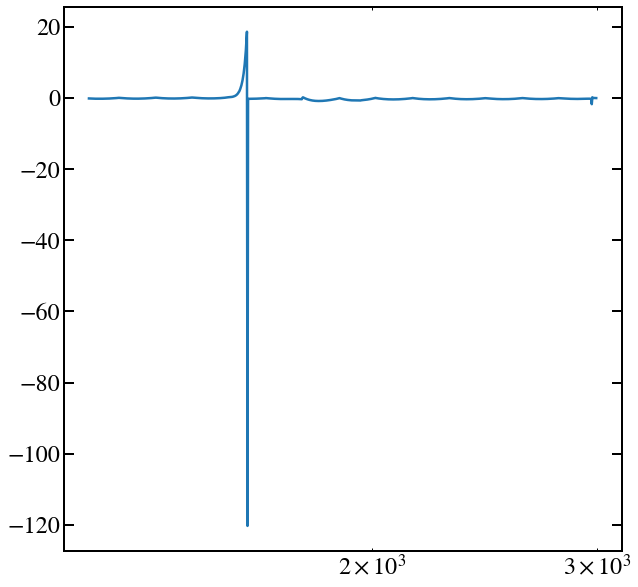

In [108]:
ind = 0
chan = 4
ran = 917
plt.figure()
ax = plt.gca()
ax.set_xscale('log')

# plt.plot(idl_redshift, (f_DH_list[ind,:,0]-f_idl_list[ind,0])/f_idl_list[ind,0])

plt.plot(idl_redshift[:917], (f_DH_data[0][6][0][:,chan]-f_idl_list[ind,chan,:917])/f_idl_list[ind,chan,:917])

# Compute DH f(z)'s

structure formation and useful definitions

In [83]:
tau=.5e25
sigmav = 3e-27

if inj_type == 'decay':
    def struct_boost(rs):
        return 1
else:
    struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))
    log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))
    def struct_boost(rs):
        if rs<76:
            return np.exp(log_struct_interp(np.log(rs)))
        else:
            return 1 

photeng = highengphot_tf_interp.eng
eleceng = lowengelec_tf_interp.eng

In [102]:
%autoreload

def get_column(i, f_DH_list, inj_particle='electron', inj_type='decay', end_rs=5):
    """ inj_type = 'swave' has not been worked out yet
    """
    #injection energy, DM mass, center-of-mass energy
    Einj = 10**log10eng[i]
    mDM = 2*Einj + 2*mass
    Ecom=mDM
    
    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)
    
    if inj_type == 'swave':
        mDM = mDM/2
        Ecom = 2*mDM   
    
    if inj_particle == 'electron':
        Etmp = eleceng[eleceng < Einj][-1]
        elec_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            eleceng
        )
        elec_spec_init.rs = 3000
        elec_spec_init.switch_spec_type()
        
        phot_spec_init = Spectrum(photeng,
                                 np.zeros_like(photeng),
                                 spec_type='N',
                                 rs=3000)
    else:
        Etmp = photeng[photeng < Einj][-1]
        phot_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            photeng
        )
        phot_spec_init.rs = 3000
        phot_spec_init.switch_spec_type()
        
        elec_spec_init = Spectrum(eleceng,
                                 np.zeros_like(eleceng),
                                 spec_type='N',
                                 rs=3000)

    f_DH_list[i] = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_N, rate_func_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=1, std_soln=True,
        reion_switch=False,
        struct_boost=None,
        ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
        xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
        use_tqdm=True
    )

In [106]:
f_DH_data = [None for i in np.arange(40)]

for k in tqdm(np.arange(1)):
    get_column(k, f_DH_data, inj_particle=inj_particle, inj_type=inj_type, end_rs=1200)
    
f_DH_list2 = np.array([
    f_DH[6] for f_DH in f_DH_data
])

# pickle.dump(f_DH_list, open('/Users/gregoryridgway/Desktop/DM/ih_continuous_phot/f_decay_'+inj_str+'.p', 'wb'))

TypeError: 'NoneType' object is not subscriptable

In [45]:
if inj_particle == 'electron':
    f_DH_data_elec = [None for i in np.arange(40)]
    for k in tqdm(np.arange(40)):
        get_column(k, f_DH_data_elec, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.999)
        f_DH_list = np.array([
            f_DH[6] for f_DH in f_DH_data_elec
        ])
else:
    f_DH_data_phot = [None for i in np.arange(40)]
    for k in tqdm(np.arange(40)):
        get_column(k, f_DH_data_phot, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.999)
        f_DH_list = np.array([
            f_DH[6] for f_DH in f_DH_data_phot
        ])

pickle.dump(f_DH_list, open('/Users/gregoryridgway/Desktop/DM/ih_continuous_phot/f_decay_'+inj_str+'.p', 'wb'))

../darkhistory/spec/spectra.py:401: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(type(other), float)
../darkhistory/spec/spectra.py:402: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  or np.issubdtype(type(other), int)
/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


TypeError: 'NoneType' object is not subscriptable

# Plot f contours

In [59]:
def get_fdiff(inj_type, inj_particle, channel):
    folder = inj_str+'_'+inj_type+'/'
    
    eng = 10**log10eng   
#     tmp = np.concatenate([np.arange(20), np.array([21,22,23,24,26,27,28,29,32,33,34,36,37,38,39])])
    tmp=np.arange(40)

    rs_list = np.array([3000*np.exp(-0.001*i) for i in np.arange(6398)])

    ind = {'H_ion' : 0, 'He_ion' : 1, 'exc' : 2, 'heat' : 3, 'cont' : 4}[channel]
#     title = r'\bf{$f_{H ion}$}'
    title = channel

    plt.figure()
    ax=plt.gca()
    ax.loglog()
    levels=[0,.01,.05,.1,.5]#,.2,.3,.4,.5,1]
    
    diffs = np.zeros_like(f_DH_list[tmp,:,ind])
    diffs = np.abs(
        f_DH_list[tmp,:,ind] - f_idl_list[tmp,ind,:]
    )/f_idl_list[tmp,ind,:]
    
    cs2 = ax.contourf(eng, rs_list, np.transpose(diffs), levels = levels,
#                      norm=matplotlib.colors.LogNorm(),
                     cmap=matplotlib.cm.RdBu_r)
#     ax.contour(eng,rs_list[25:],
#                np.transpose(diffs)[25:],  
#                levels=levels[1:-1],
#                colors='k',
#                alpha=.4
#               )
    cbar = plt.colorbar(cs2, ticks=levels)
    
    plt.title(title)
#     plt.ylabel(r'Redshift ($1+z$)')
    plt.ylabel(r'Redshift (1+z)')
    plt.xlabel(r'Kinetic Energy [eV]')

#     plt.savefig(
#         '/home/gridgway/Desktop/f_contour_debug/'+folder+'f'+inj_particle+'_'+inj_type+'_'+channel+'_IDLdiffs.pdf'
#     )

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


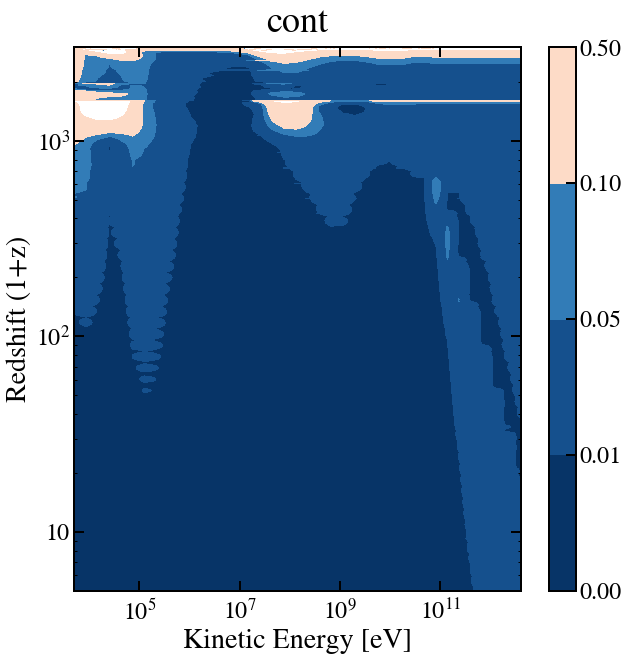

In [71]:
get_fdiff(inj_type, inj_str, 'cont')

# SCRATCHWORK and NOTES

-Compute T(E,z_in, z_dep) by doing a delta function injection

-Why don't we ever keep track of how much DM is being depleted through annihilation/decay?

-Why don't we go above 5 TeV?

TODO:
- make contour plots
    - Pick a mass and make the plot corresponding to a vertical line going through the contour plot
    - Make a course contour plot
    - Once everything is debugged, make a very fine contour plot
- Clean up this Example12
    - migrate the main evolve function into a main.py that is conspicuous for the casual user
    - Change the inputs so that xe_init and T_init are computed for the user.
    - Make sure that the transfer functions are never seen (take them out of the input)
    - plots comparing back-reaction and no back-reaction
    - allow electron annihilation


- Structure Formation
    - swave
    - on/off switch
    - optimistic/conservative
    - (just a change to the annihilation rate)
    
- minimum lifetime (do this first, structure independent)/maximum cross-section
    - residual plot of with back-reaction vs. not back-react (temperature), contour plots
    - for each mass pick the minimum tau or maximum cross-section and compare the std_switch on or off
    
- New 21cm sensitivity
    - Hongwan's plots, but now with DarkHistory

# NEED TO CHECK

In [393]:
import darkhistory.low_energy.lowE_deposition as lowE_dep
%autoreload

time=-2
tau=1e23
rs_tmp = a1[3][time].rs
print(sum(lowE_dep.compute_fs(
    a1[4][time], 
    a1[3][time], 
    np.array([1-xe_std(rs_tmp),0,0]), 
    rate_func_eng(rs_tmp), 
    .002/phys.hubble(rs_tmp), 
    0
))*rate_func_eng(rs_tmp)*.002/phys.hubble(rs_tmp)/phys.nB/rs_tmp**3)
print(a1[4][time].toteng()+a1[3][time].toteng())

0.0054045385439492315
0.005405394701886692


# Scratch

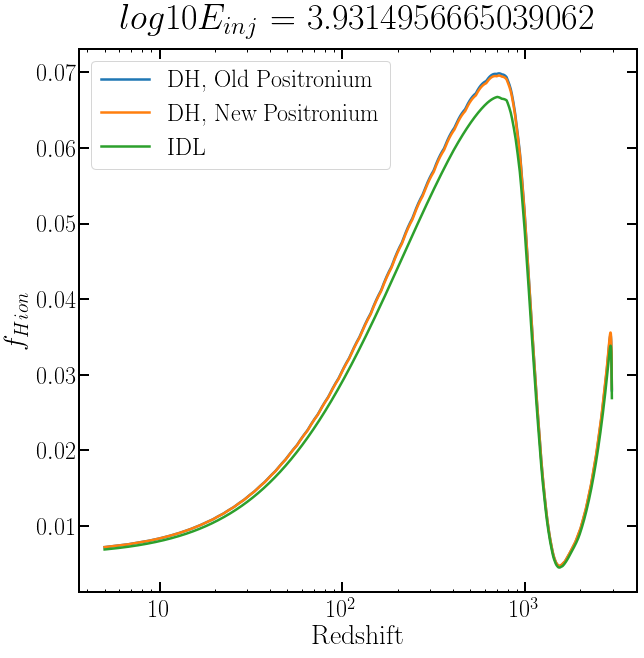

In [27]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')

Eind=1
ind=0

plt.title('$log10E_{inj}$ = '+str(log10eng[Eind]))
plt.plot(rs_list[10:-1], f_decay_elec[Eind,10:,ind], label='DH, Old Positronium')
plt.plot(rs_list[10:-1], data_elec[6][10:,ind], label='DH, New Positronium')
plt.plot(rs_list[10:-1], f_idl_list[Eind,ind,10:-1], label='IDL')

# plt.plot(rs_list[10:-1], (f_decay_elec[Eind,10:,ind]-f_idl_list[Eind,ind,10:-1])/f_idl_list[Eind,ind,10:-1], label='DH')

plt.ylabel(r'$f_{Hion}$')
plt.xlabel(r'Redshift')

plt.legend()

# plt.savefig('/home/gridgway/Desktop/fHion_discrepancy')

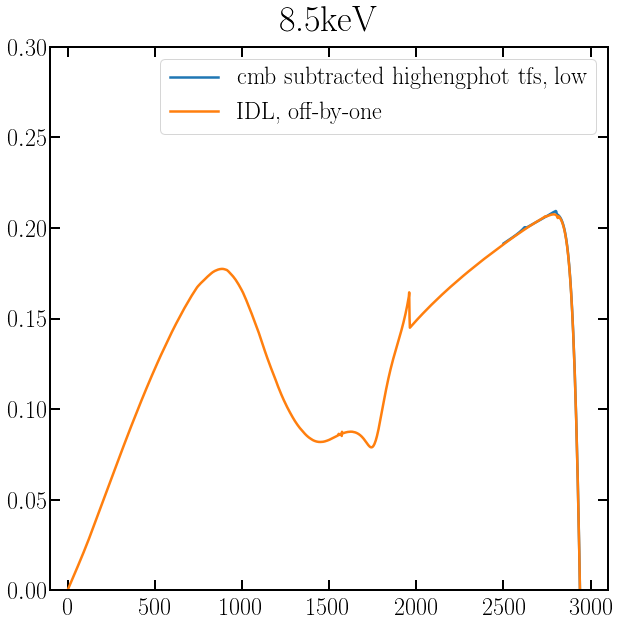

In [825]:
f_decay_phot0 = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot.p", "rb"))
rs_list = [3000*np.exp(-.001*i) for i in np.arange(6397)]

plt.figure()
ax=plt.gca()
# ax.loglog()
plt.axis([-100,3100,0,.3])
plt.title('8.5keV')


plt.plot(data_phot0[3].rs[:-1], data_phot0[6][0][:,4], label='cmb subtracted highengphot tfs, low')
# plt.plot(data_phot[3].rs[:-1], data_phot1[6][0][:,4], label='cmb subtracted lowengphot tfs, low')
# plt.plot(rs_list, f_decay_phot[1,:,4], label='cmb subtracted highengphot tfs')
# plt.plot(rs_list, f_decay_phot0[1,:,4], label='no cmb subtraction')
plt.plot(rs_list, f_idl_list[1,4,:-1], label='IDL, off-by-one')



# plt.plot(rs_list[10:], np.abs((f_idl_list[1,4,10:-1]-f_decay_phot[1,10:,4])/f_idl_list[1,4,10:-1]), label='IDL')
# plt.plot(rs_list[10:], np.abs((f_idl_list[1,4,10:-1]-f_decay_phot0[1,10:,4])/f_idl_list[1,4,10:-1]), label='IDL')

# plt.plot(data_phot[3].rs[:-1], data_phot[6][0][:,4]+data_phot[6][1][:,4], label='cmb subtracted highengphot tfs')

# plt.plot(idl_redshift[1:len(entries)+1], idl_flist[:,4], label='IDL, low')

# plt.plot(idl_redshift[:len(entries)], np.abs((idl_flist[:,4]-data_phot[6][0][:,4]-data_phot[6][1][:,4])/idl_flist[:,4]), label='IDL')

plt.legend()

# plt.savefig(
#     '/home/gridgway/Desktop/f_cont_offbyone_error.png'
# )

In [775]:
%autoreload
#fs from idl run
from darkhistory.low_energy.lowE_electrons import make_interpolator
from darkhistory.low_energy import lowE_deposition as lowE_dep
MEDEA_interp = make_interpolator()

E_tmp=10**log10eng[1]
entries=np.arange(4000)+1

idl_flist = [
    lowE_dep.compute_fs(
        MEDEA_interp,
        phot_spec=Spectrum(idl_energy, phot, rs=rs),
        elec_spec=Spectrum(idl_eleceng, elec*0, rs=rs),
        x = np.array([1-xe, 0, 0]),
        dt = .001/hub,
#         highengdep = highdep_interps.get_val(xe, rs)[indTmp],
        highengdep = highdeposited*np.array([1,1,1,0]),
        cmbloss = loss * hub/phys.hubble(rs*np.exp(.002)), #THIS factor of dt(z+2dz)/dt(z) compensates for IDL's off-by-one error
#         dE_dVdt_inj = phys.inj_rate('decay', rs, mDM=E_tmp, tau=tau)*2
        dE_dVdt_inj = 2*E_tmp*rate*phys.nB*rs**3
    )
    for xe, rs, phot, elec, loss, hub, rate, highdeposited in zip(data.field('hionfraction')[0][entries], 
                                   idl_redshift[entries],                            
                                   idl_lowengphot[entries],
                                   idl_lowengelec[entries],
                                   idl_cmblosstable[entries-1],
                                   data.field('hubblerate')[0][entries],
                                   data.field('annrate')[0][entries],
                                   np.transpose(idl_highengdep[:,entries]))]

idl_flist=np.array(idl_flist)

In [142]:
import multiprocessing  # the module we will be using for multiprocessing

def work(number):
    """
    Multiprocessing work
    
    Parameters
    ----------
    number : integer
        unit of work number
    """
    
    print("Unit of work number %d" % number)  # simply print the worker's number
    
def nonsense():
    print("There are %d CPUs on this machine" % multiprocessing.cpu_count())
    number_processes = 1
    pool = multiprocessing.Pool(number_processes)
    total_tasks = 4
    tasks = range(total_tasks)
    results = pool.map_async(get_column, tasks)
    print(results)
    pool.close()
    pool.join()

In [142]:
import multiprocessing  # the module we will be using for multiprocessing

def work(number):
    """
    Multiprocessing work
    
    Parameters
    ----------
    number : integer
        unit of work number
    """
    
    print("Unit of work number %d" % number)  # simply print the worker's number
    
def nonsense():
    print("There are %d CPUs on this machine" % multiprocessing.cpu_count())
    number_processes = 1
    pool = multiprocessing.Pool(number_processes)
    total_tasks = 4
    tasks = range(total_tasks)
    results = pool.map_async(get_column, tasks)
    print(results)
    pool.close()
    pool.join()

In [142]:
import multiprocessing  # the module we will be using for multiprocessing

def work(number):
    """
    Multiprocessing work
    
    Parameters
    ----------
    number : integer
        unit of work number
    """
    
    print("Unit of work number %d" % number)  # simply print the worker's number
    
def nonsense():
    print("There are %d CPUs on this machine" % multiprocessing.cpu_count())
    number_processes = 1
    pool = multiprocessing.Pool(number_processes)
    total_tasks = 4
    tasks = range(total_tasks)
    results = pool.map_async(get_column, tasks)
    print(results)
    pool.close()
    pool.join()

In [4]:
def get_fcontour(inj_type, inj_particle, channel):
    if inj_particle is 'elec':
        coarsen_factor = 16

        if inj_type is 'decay':
            f_for_plot = f_decay_elec.copy()
            folder='elec_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_elec.copy()
            folder='elec_swave/'
    else:
        coarsen_factor = 8

        if inj_type is 'decay':
            f_for_plot = f_decay_phot.copy()
            folder='phot_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_phot.copy()
            folder='phot_swave/'
    
    eng = 10**log10eng[:len(f_for_plot)]
    rs_list = [3000*np.exp(-0.001*coarsen_factor*(i)) for i in np.arange(6400/coarsen_factor)]

    if channel is 'H_ion':
        ind=0
        title = r'\bf{$f_{H ion}$}'
    elif channel is 'He_ion':
        ind=1
        title = r'\bf{$f_{He ion}$}'
    elif channel is 'exc':
        ind=2
        title = r'\bf{$f_{exc}$}'
    elif channel is 'heat':
        ind=3
        title = r'\bf{$f_{heat}$}'
    elif channel is 'cont':
        ind=4
        title = r'\bf{$f_{cont}$}'

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 5, 2e3])

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])
    elif inj_type is 'swave':
        if channel is 'H_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2])
        elif channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([5e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 1e2, 3e2])
        elif channel is 'heat':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 5, 1e1, 3e1])
        elif channel is 'cont':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2])

                
    f_for_plot[f_for_plot < levels[0]] = levels[0]*(1+.01)
    f_for_plot[f_for_plot > levels[-1]] = levels[-1]*(1-.01)
    
    levels2 = np.exp(np.linspace(np.log(levels[0]),np.log(levels[-1]),100))
    cs = ax.contourf(eng,rs_list,
                     np.transpose(f_for_plot[:,:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels2,
                     cmap=matplotlib.cm.RdBu_r)
    ax.contour(eng,rs_list,
               np.transpose(f_for_plot[:,:,ind]),  
               levels=levels[1:-1],
               colors='k',
               alpha=.4
              )

    cbar = plt.colorbar(cs, ticks=levels)
    cbar.ax.set_xticklabels(str(levels))

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

#     direc = '/Users/GregoryRidgway/Desktop/Dark Matter/DH_Data/'
#     plt.savefig(
#         direc+'f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
#     )